In [1]:
"""""""""""""""""
Required packages
"""""""""""""""""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random
import imageio
import cv2

In [2]:
# Importation of the dataset

data_dir = "flickr30k_images/flickr30k_images/"

df = pd.read_csv("flickr30k_images/results.csv", sep="|")

df.head(10)

image_name  comment_number  \
0  1000092795.jpg               0   
1  1000092795.jpg               1   
2  1000092795.jpg               2   
3  1000092795.jpg               3   
4  1000092795.jpg               4   
5    10002456.jpg               0   
6    10002456.jpg               1   
7    10002456.jpg               2   
8    10002456.jpg               3   
9    10002456.jpg               4   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1   Two young , White males are outside near many...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  
5   Several men in hard hats are operating a gian...  
6   Workers look down from up above on a piece of...  
7   Two men working on a machine wearing hard hats .  
8              Four men on top of a tall structure .  
9                         Three men on a large rig .

In [3]:
# Get the name of each columns

df.columns

Index(['image_name', ' comment_number', ' comment'], dtype='object')

In [4]:
# Extraction of image's filename

filename_df = df["image_name"]
filename = filename_df.values

In [5]:
# Creation of our training dataset

nb_files = len(filename) # number of images in the whole dataset
nb_dataset = 10000 # size of training data

files_image_analysis = []
compteur = 0
while compteur < nb_dataset:
    temp = random.choice(filename)
    if temp not in files_image_analysis:
        files_image_analysis.append(temp)
        compteur += 1

print(len(files_image_analysis))

print(files_image_analysis)

10000
['3441959314.jpg', '2445283938.jpg', '1122579380.jpg', '416551084.jpg', '3084752813.jpg', '4374914744.jpg', '3102521400.jpg', '6473658663.jpg', '447691737.jpg', '3415178926.jpg', '2254697851.jpg', '3349258288.jpg', '4859789355.jpg', '2110979954.jpg', '8117746605.jpg', '576075451.jpg', '421706022.jpg', '3646927481.jpg', '3246016210.jpg', '2703515269.jpg', '3251669502.jpg', '2367949659.jpg', '6972691908.jpg', '2883099128.jpg', '1547327107.jpg', '60644154.jpg', '3533470072.jpg', '2569653795.jpg', '1870425036.jpg', '5403974988.jpg', '2417701468.jpg', '2652522323.jpg', '3503483247.jpg', '2344625369.jpg', '2536991887.jpg', '1693115528.jpg', '4517839686.jpg', '4538926478.jpg', '4755080905.jpg', '1254659.jpg', '1369162.jpg', '3848343761.jpg', '2375282125.jpg', '6243067522.jpg', '3490867290.jpg', '3242088278.jpg', '4648440498.jpg', '5812770731.jpg', '2608116127.jpg', '3049191866.jpg', '5542771977.jpg', '3619416477.jpg', '1428839421.jpg', '2472250097.jpg', '7333560206.jpg', '3020714541.jpg

(375, 500, 3)

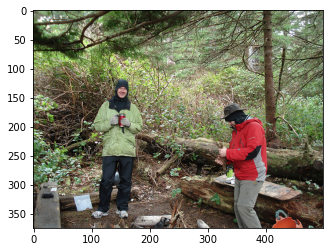

In [6]:
# Useful functions for images

def read_image(file_name):
    img_color = imageio.imread(file_name)
    return img_color

def display_image(img_in):
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

img = read_image(data_dir+files_image_analysis[0])
display_image(img)
img.shape

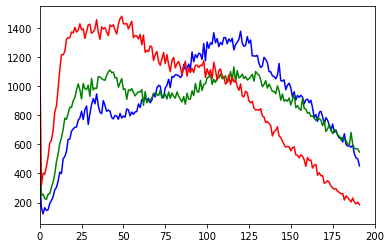

(576, 1)


In [7]:
# Test for the histogram of one image

color = ('b','g','r')
img_hist = []
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[192],[0,192])
    #histr_norm = cv2.normalize(histr, histr, norm_type=cv2.NORM_MINMAX)
    img_hist += histr.tolist() 
    plt.plot(histr,color = col)
    plt.xlim([0,200])
plt.show()

print(np.shape(img_hist))

In [8]:
# Concatenation of the 3 histograms (RGB) of each image of the dataset into one single array
# The length will be the sum of the length of each histogram 

dataset = []
for file_name in files_image_analysis:
    img = read_image(data_dir+file_name)
    img_hist = []
    for i in range(3):
        histr = cv2.calcHist([img],[i],None,[192],[0,192])
        #histr_norm = cv2.normalize(histr, histr, norm_type=cv2.NORM_MINMAX)
        img_hist += (histr.reshape(-1,1)).tolist()
    dataset.append(img_hist)

In [9]:
print(np.array(dataset)[:,:,0].shape)

(10000, 576)


In [10]:
def CAVI_update_phi(X, m, s2):
    """
    :param X: our data points
    :param m: estimated mean in the law q
    :param s2: estimated variance in the law q
    :return: the updated phi
    """
    
    first_term = X @ m.T

    second_term = - (np.linalg.norm(m, axis=1)**2 + s2.trace(axis1=-2, axis2=-1)) / 2
    second_term = second_term.reshape(1, -1)
    x = first_term + second_term
    x = x - x.max(axis=1, keepdims=True) ## avoid pb of overflow

    phi = np.exp(x)
    phi = phi / phi.sum(1, keepdims=True)
    
    return phi

def CAVI_update_mu_s2(X, phi, sigma2, K, dim):
    """
    :param X: our data points
    :param phi: estimated phi in the law q
    :param sigma2: covariance matrix of the means of the clusters
    :param K: number of clusters
    :param dim: number of dimensions of the problem
    :return: the updated m and s2
    """

    p = phi.T.sum(axis=1, keepdims=True)
    s2_inv = np.linalg.inv(sigma2) + p.reshape(-1,1)[:,:,None] * np.identity(dim)
    s2 = np.linalg.inv(s2_inv)

    a = phi.T @ X
    m  = (s2 @ a[:,:,None])[:,:,0]
    return m, s2

def elbo(X, phi, m, s2, sigma2):
    epsilon = 1e-10 
    phi += epsilon
    t1 = np.linalg.det(s2).reshape(-1,1)[:,:,None] - m[:,None,:] @ (np.linalg.inv(sigma2) @ m[:,:,None] + (np.linalg.inv(sigma2) @ s2).trace(axis1=-2, axis2=-1)[:,None,None])
    t1 = t1.sum()/2
    
    second_term = - (np.linalg.norm(m, axis=1)**2 + s2.trace(axis1=-2, axis2=-1)) / 2
    second_term = second_term.reshape(1, -1)
    second_term = (X @ m.T - np.log(phi)) + second_term

    second_term = second_term * phi
    t2 = second_term.sum()
    return t1 + t2

def CAVI_mixture_Gaussian(X, m, s2, phi, sigma2, max_iter = 500, epsilon = 1e-2):
    elbos  = [elbo(X, phi, m, s2, sigma2)]
    m_est  = [m]
    s2_est = [s2]
    phi_est = [phi]

    k, dim = phi.shape[1] , m.shape[1] 
    for it in range(1, max_iter + 1):
        phi = CAVI_update_phi(X, m, s2)
        m, s2 = CAVI_update_mu_s2(X, phi, sigma2, K, dim)
    
        m_est.append(m)
        s2_est.append(s2)
        phi_est.append(phi)

        elbos.append(elbo(X, phi, m, s2, sigma2))

        if np.abs(elbos[-2] - elbos[-1]) <= epsilon:
            break

    return elbos, m_est, s2_est, phi_est

Run the algorithm

In [13]:
K = 30 # nb of clusters
dim = 576
dataset = np.array(dataset)[:,:,0]

phi_init = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*K, nb_dataset)
m_init = np.random.normal(0, 10, (K,dim))
s2_init = np.random.normal(0,10,(K,dim,dim))
sigma2_init = np.identity(dim)
print(phi_init.shape)
print(s2_init.shape)
print(m_init.shape)
print(sigma2_init.shape)

(10000, 30)
(30, 576, 576)
(30, 576)
(576, 576)


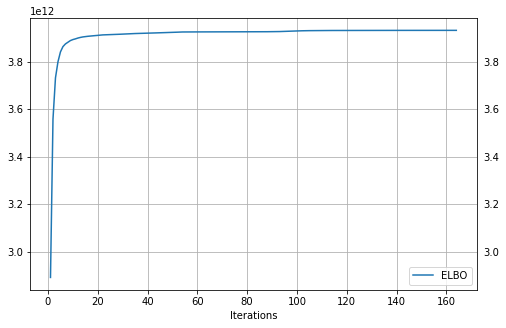

In [14]:
fig = plt.figure(figsize=(8,5))
elbos, m_est, s2_est, phi_est = CAVI_mixture_Gaussian(dataset, m_init, s2_init, phi_init, sigma2_init)
plt.plot(np.array(elbos),label = 'ELBO')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Iterations')
plt.legend();

In [15]:
print(elbos)

[nan, 2891785813552.5913, 3558074536202.806, 3731907374941.8394, 3799581823686.9424, 3841225363880.217, 3863517014670.7275, 3874862954444.24, 3882220249131.1436, 3889021417466.6636, 3893204758318.767, 3896112257982.7085, 3899593837670.9517, 3902226972436.214, 3904334520636.993, 3905809304536.0127, 3907025958301.536, 3908057745407.7983, 3909015552168.3135, 3910088078557.1724, 3911274609167.806, 3912276505024.513, 3912890077616.251, 3913234977429.013, 3913563077191.373, 3913875472741.2217, 3914304545526.983, 3914758485361.5884, 3915380608537.8306, 3915715037418.697, 3916254023547.144, 3916715238984.9707, 3917300171004.006, 3917809804927.486, 3918300179188.859, 3918622677560.162, 3918902985517.4766, 3919216601101.13, 3919588549932.322, 3919986187590.9385, 3920339964316.6704, 3920663199058.865, 3920897847587.3506, 3921168482473.971, 3921628500704.405, 3921943048030.533, 3922274908618.856, 3922550006583.37, 3922827557744.028, 3923132307404.7344, 3923511089571.2417, 3923877918185.0044, 39243

In [16]:
m_est[-1]

array([[3347.98901099, 4331.79120879, 6352.38461538, ...,  155.81318681,
         152.26373626,  148.21978022],
       [1101.58108108,  525.17972973,  438.83783784, ...,  578.95675676,
         586.48918919,  594.57027027],
       [2026.3452381 , 1555.5297619 , 1883.05952381, ...,  249.36309524,
         247.94047619,  244.61904762],
       ...,
       [ 667.18768328,  288.97360704,  236.74486804, ...,  257.78592375,
         253.80351906,  251.26099707],
       [1101.58108108,  525.17972973,  438.83783784, ...,  578.95675676,
         586.48918919,  594.57027027],
       [ 481.85775862,  215.85775862,  190.04310345, ..., 1119.67672414,
        1077.84482759, 1038.68534483]])

In [17]:
s2_est[-1]

array([[[0.01098901, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.01098901, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.01098901, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.01098901,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.01098901, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.01098901]],

       [[0.00675676, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.00675676, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.00675676, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00675676,
         0.        , 0.        ],
        [0. 

In [18]:
# Get the cluster of each images

list_clusterisation = phi_est[-1].argmax(axis=1)   
print(list_clusterisation)

[19 11 26 ...  9 18 19]


In [19]:
# Storage of each image in the cluster that belongs to it

list_cluster_image = [[] for k in range(K)]

for idx, cluster in enumerate(list_clusterisation) :
    list_cluster_image[cluster].append(files_image_analysis[idx])

print(list_cluster_image)

#for i in range(K):
#    for k in range(nb_dataset):
#        if list_clusterisation[k,i] == 1:
#            list_cluster_image[i].append(files_image_analysis[k])

[['6473658663.jpg', '4452184724.jpg', '3504105665.jpg', '4700435315.jpg', '4119134806.jpg', '407569668.jpg', '3433062788.jpg', '3793774643.jpg', '4063381040.jpg', '1296770308.jpg', '4366908113.jpg', '482907079.jpg', '2214322704.jpg', '2321764238.jpg', '3442242092.jpg', '3297272270.jpg', '6324325470.jpg', '4068908551.jpg', '4743795506.jpg', '2423856014.jpg', '22143604.jpg', '4267222130.jpg', '800387501.jpg', '28041138.jpg', '6540658813.jpg', '2458543148.jpg', '3667908724.jpg', '1239873050.jpg', '3155451946.jpg', '2324842075.jpg', '1955172907.jpg', '26067618.jpg', '2429284131.jpg', '169003493.jpg', '4508668804.jpg', '3704709223.jpg', '3724113279.jpg', '6502488897.jpg', '2245348304.jpg', '2682382530.jpg', '3121997129.jpg', '782680629.jpg', '3119174449.jpg', '3628829949.jpg', '432326912.jpg', '2983889345.jpg', '2969134945.jpg', '3604877863.jpg', '2906054175.jpg', '3234890865.jpg', '514506850.jpg', '2700147489.jpg', '3091013719.jpg', '1167908324.jpg', '2735827522.jpg', '3004290523.jpg', '46

In [20]:
# Check the population of each clusters

for k in range(K):
    print(len(list_cluster_image[k]))

90
735
503
347
40
150
77
0
301
1126
35
652
0
247
121
298
1102
372
678
1274
435
0
186
107
46
24
483
340
0
231


<ipython-input-21-371f745b5e72>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(3,3)


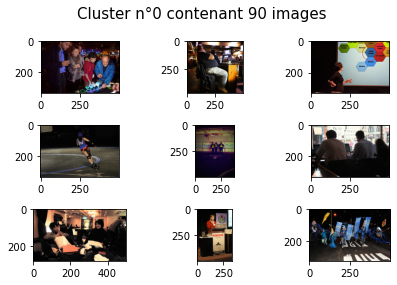

<Figure size 1080x288 with 0 Axes>

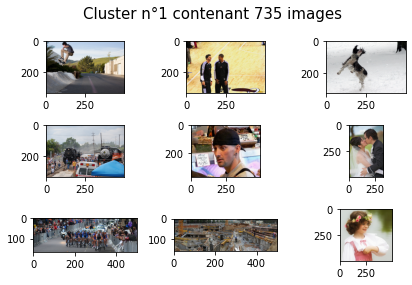

<Figure size 1080x288 with 0 Axes>

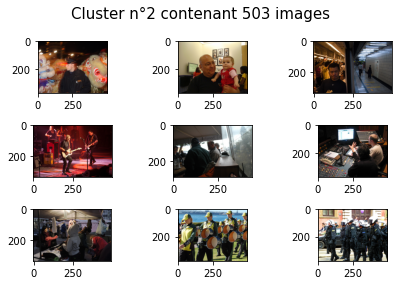

<Figure size 1080x288 with 0 Axes>

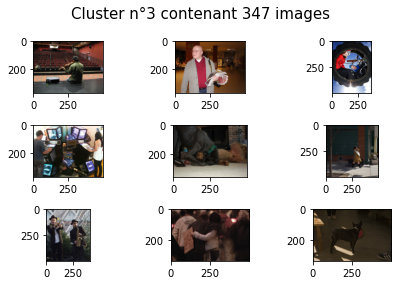

<Figure size 1080x288 with 0 Axes>

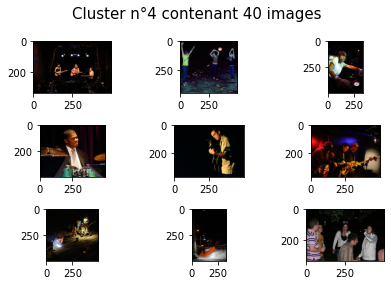

<Figure size 1080x288 with 0 Axes>

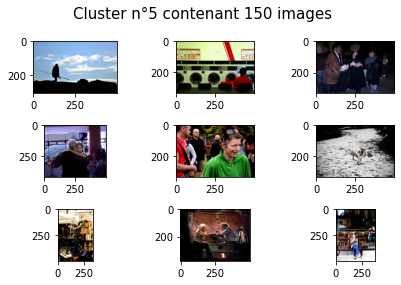

<Figure size 1080x288 with 0 Axes>

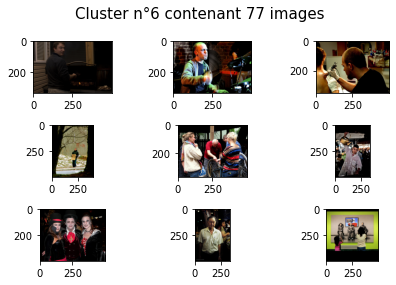

<Figure size 1080x288 with 0 Axes>

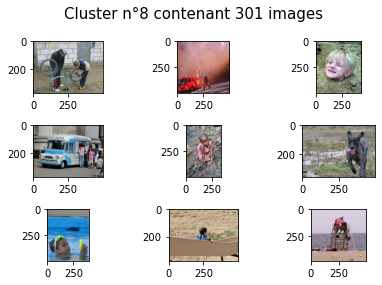

<Figure size 1080x288 with 0 Axes>

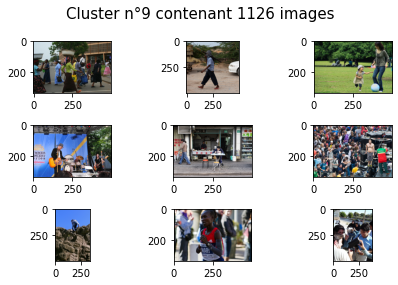

<Figure size 1080x288 with 0 Axes>

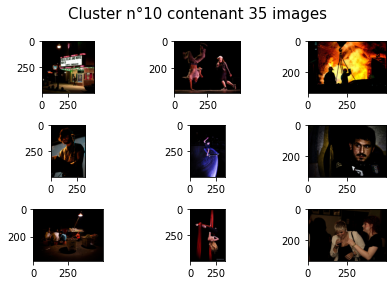

<Figure size 1080x288 with 0 Axes>

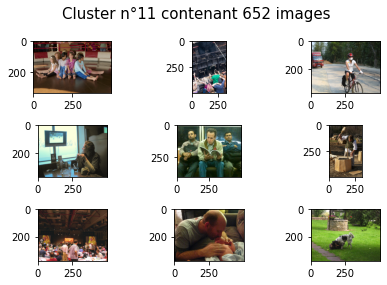

<Figure size 1080x288 with 0 Axes>

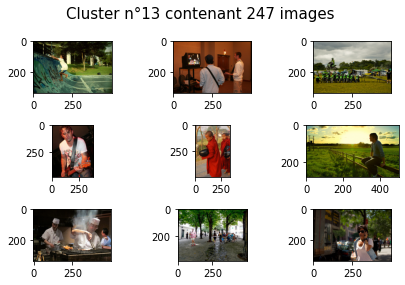

<Figure size 1080x288 with 0 Axes>

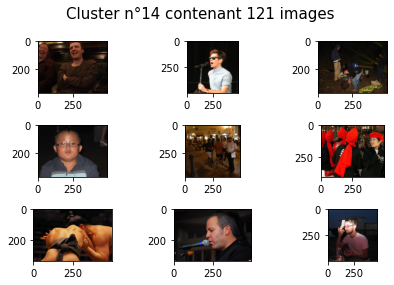

<Figure size 1080x288 with 0 Axes>

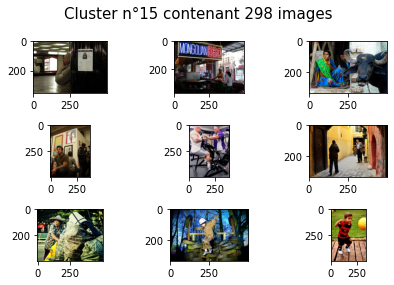

<Figure size 1080x288 with 0 Axes>

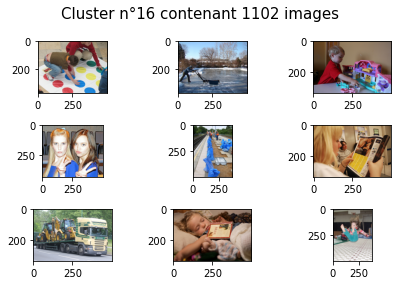

<Figure size 1080x288 with 0 Axes>

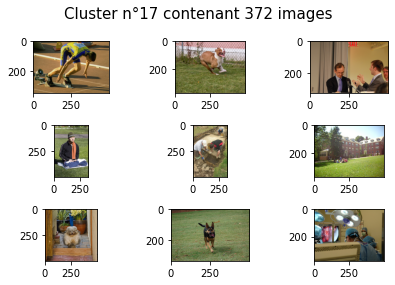

<Figure size 1080x288 with 0 Axes>

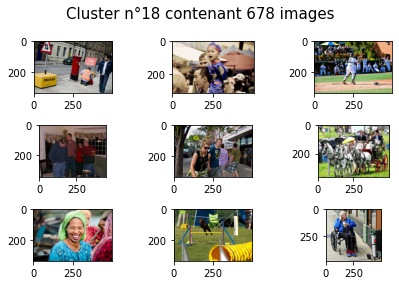

<Figure size 1080x288 with 0 Axes>

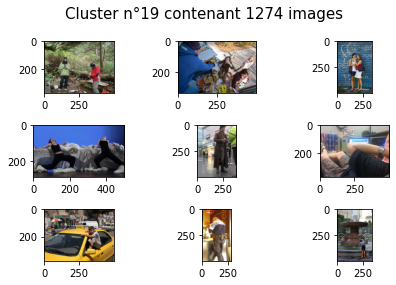

<Figure size 1080x288 with 0 Axes>

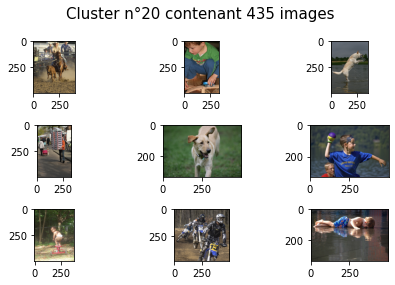

<Figure size 1080x288 with 0 Axes>

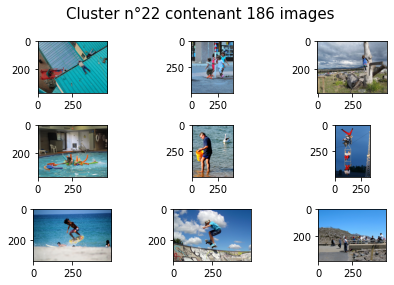

<Figure size 1080x288 with 0 Axes>

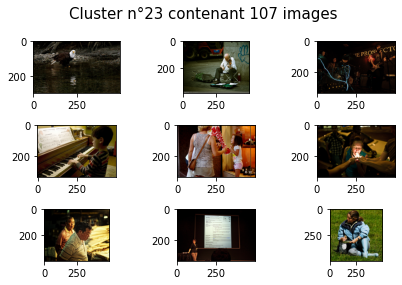

<Figure size 1080x288 with 0 Axes>

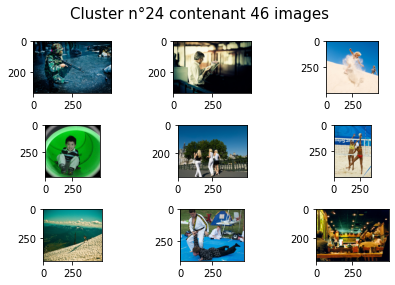

<Figure size 1080x288 with 0 Axes>

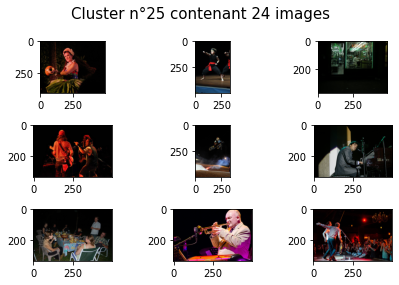

<Figure size 1080x288 with 0 Axes>

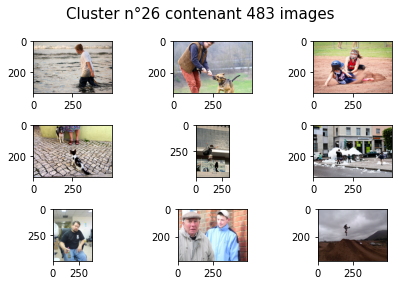

<Figure size 1080x288 with 0 Axes>

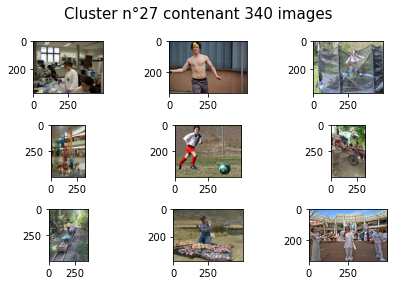

<Figure size 1080x288 with 0 Axes>

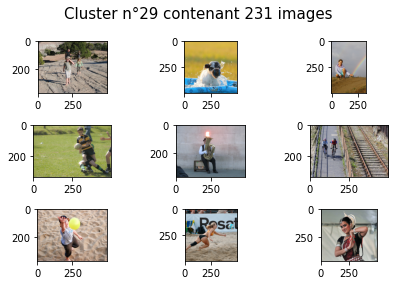

<Figure size 1080x288 with 0 Axes>

In [21]:
# Plot images of each clusters

for k in range(K):
    cluster = list_cluster_image[k]
    
    if len(cluster) >= 9 :
        #print("Cluster n°" + str(k))
        #print(len(cluster))

        f, axarr = plt.subplots(3,3)
        plt.figure(figsize=(15.0, 4.0))

        axarr[0,0].imshow(read_image(data_dir+cluster[0]))
        axarr[0,1].imshow(read_image(data_dir+cluster[1]))
        axarr[0,2].imshow(read_image(data_dir+cluster[2]))
        axarr[1,0].imshow(read_image(data_dir+cluster[3]))
        axarr[1,1].imshow(read_image(data_dir+cluster[4]))
        axarr[1,2].imshow(read_image(data_dir+cluster[5]))
        axarr[2,0].imshow(read_image(data_dir+cluster[6]))
        axarr[2,1].imshow(read_image(data_dir+cluster[7]))
        axarr[2,2].imshow(read_image(data_dir+cluster[8]))
        
        f.suptitle("Cluster n°" + str(k) + " contenant " + str(len(cluster)) + " images", fontsize=15)
        
        f.tight_layout()

<ipython-input-22-c45dfb6895f2>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15.0, 4.0))


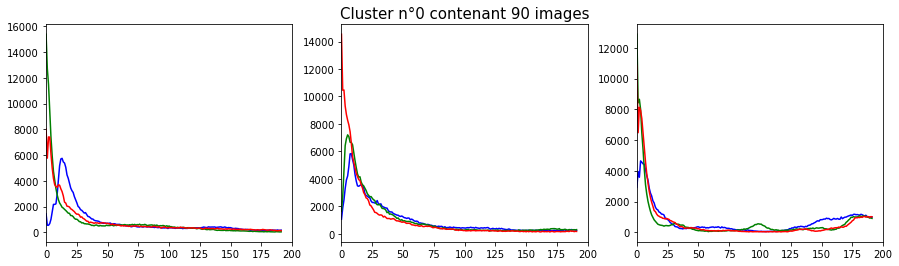

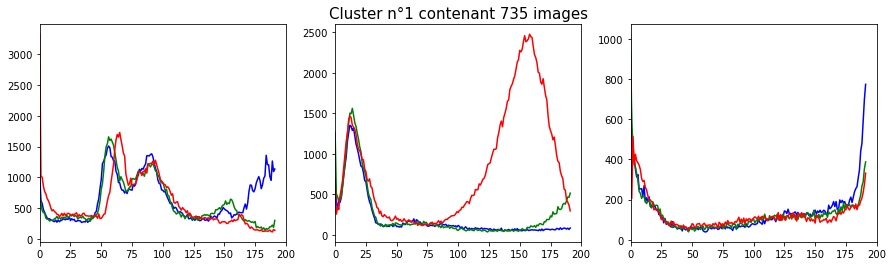

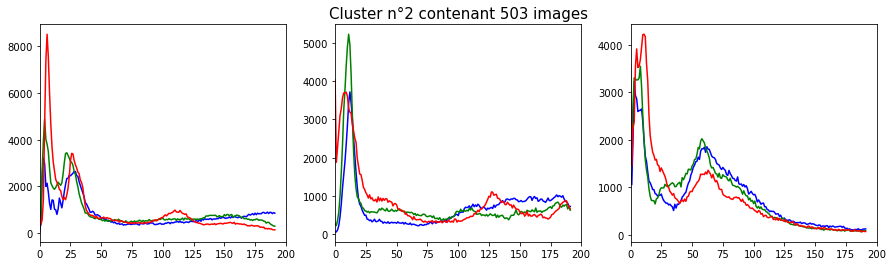

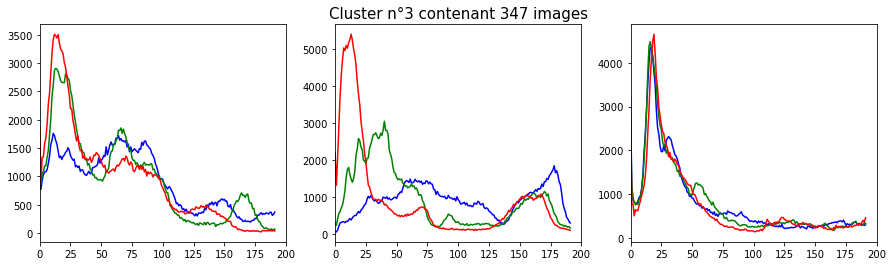

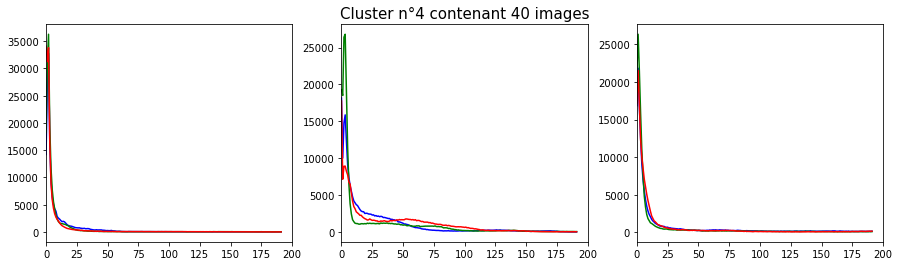

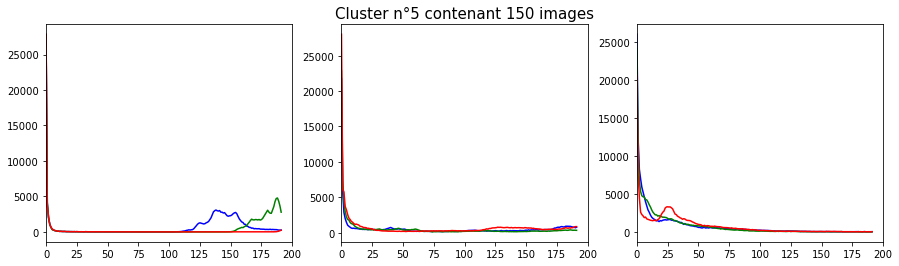

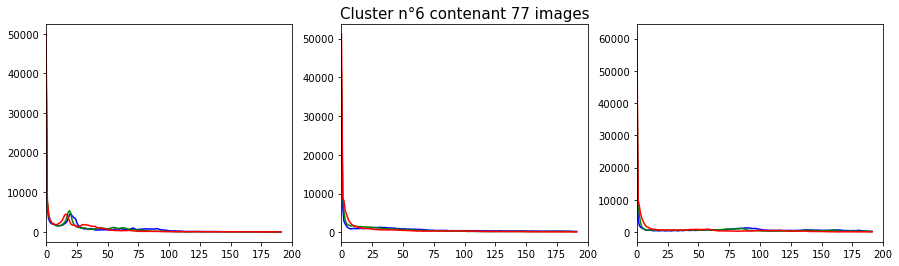

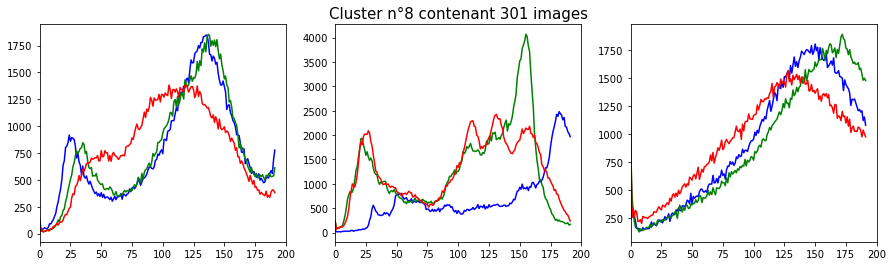

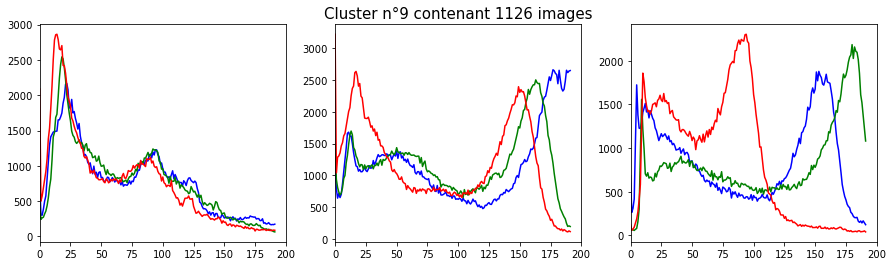

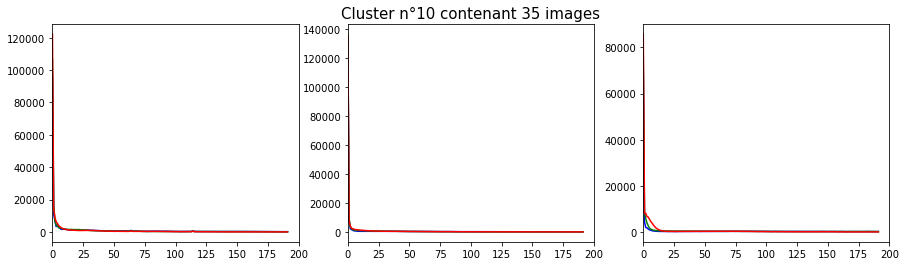

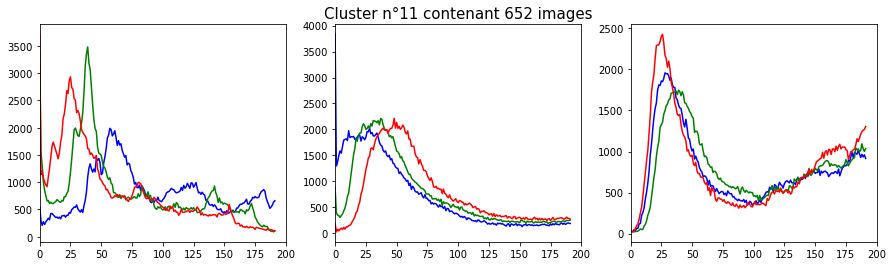

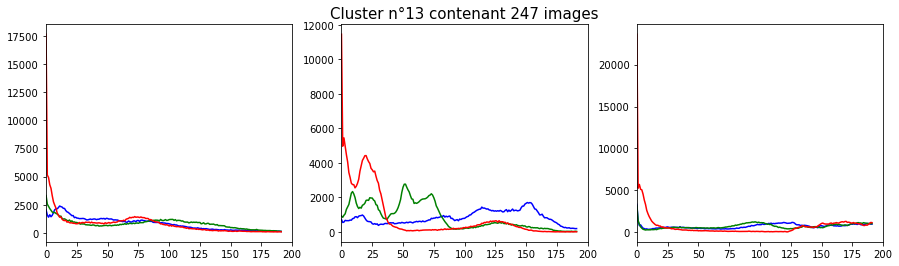

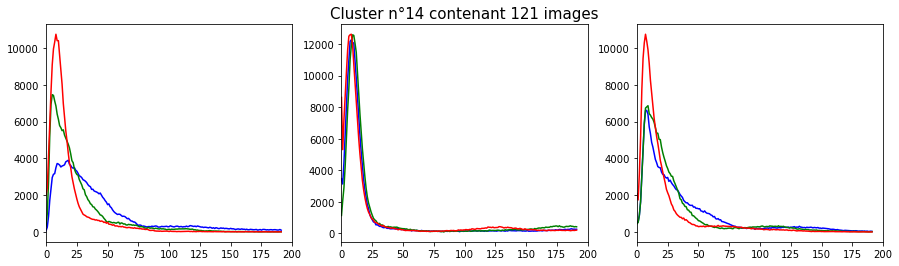

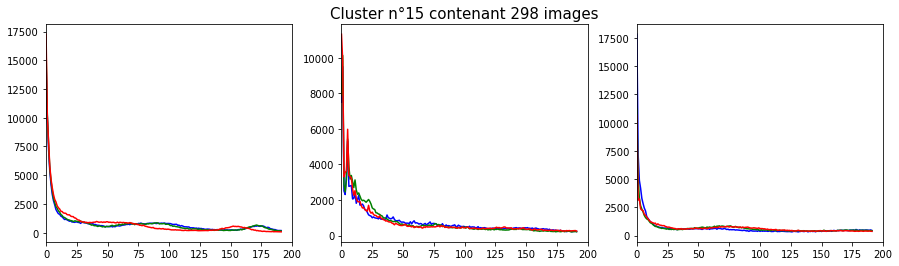

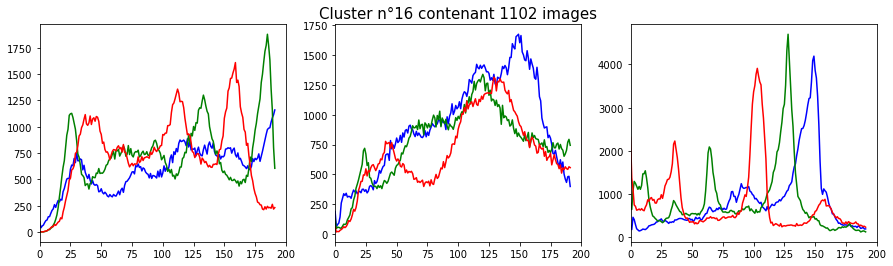

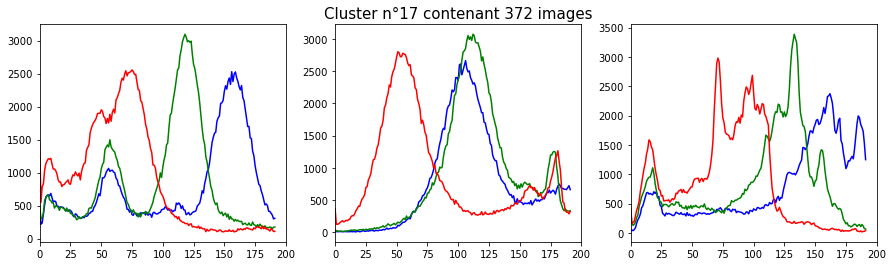

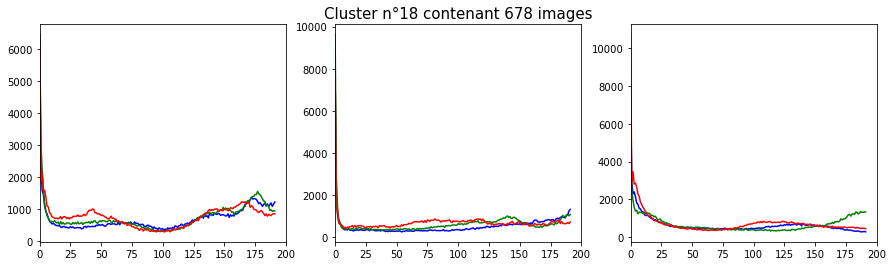

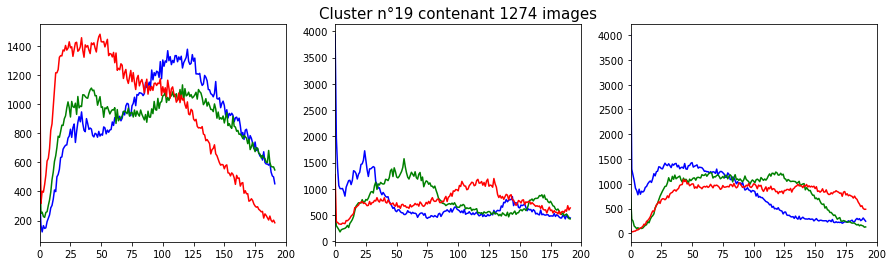

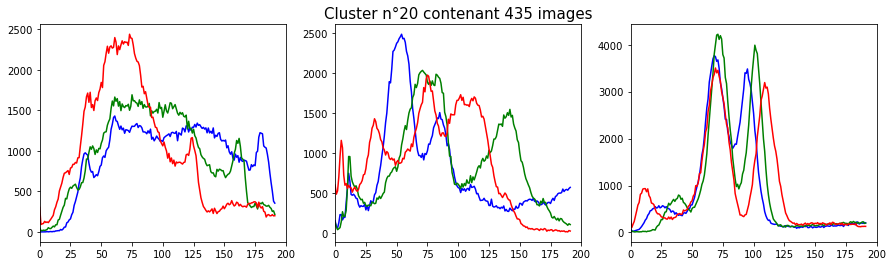

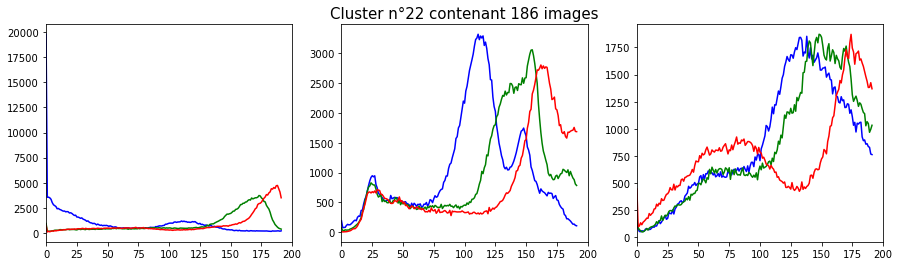

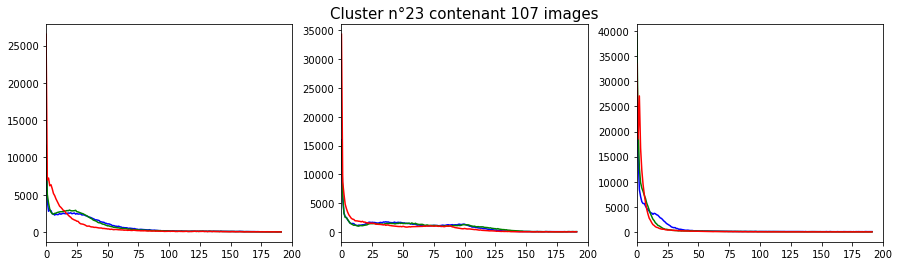

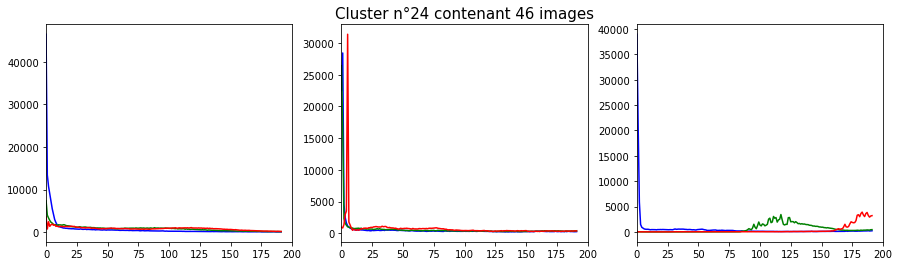

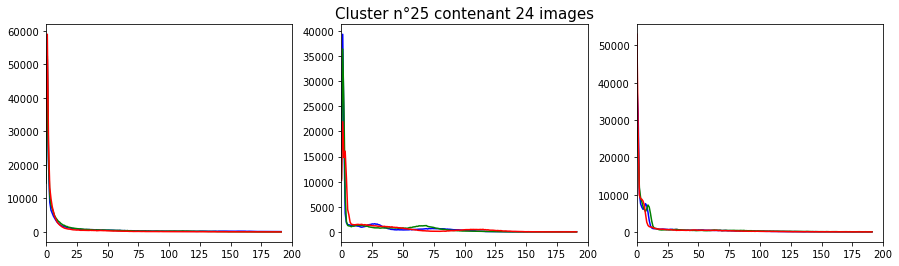

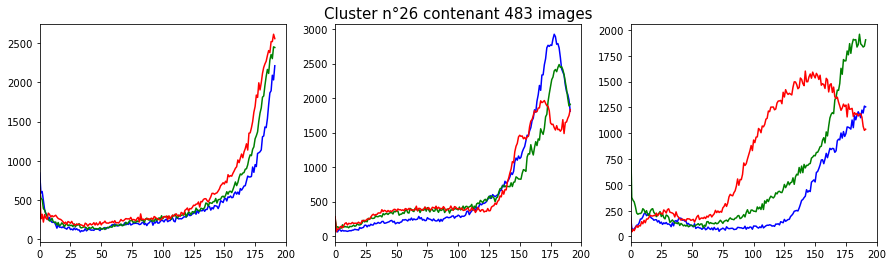

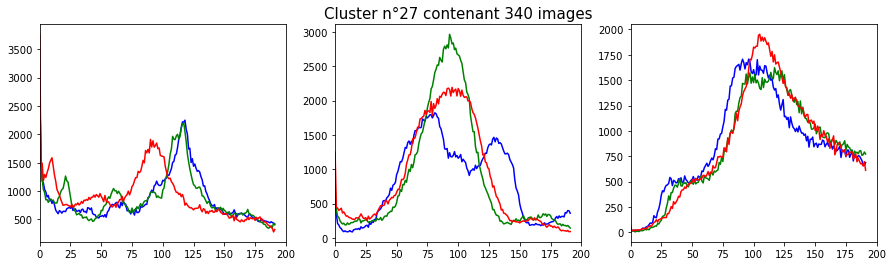

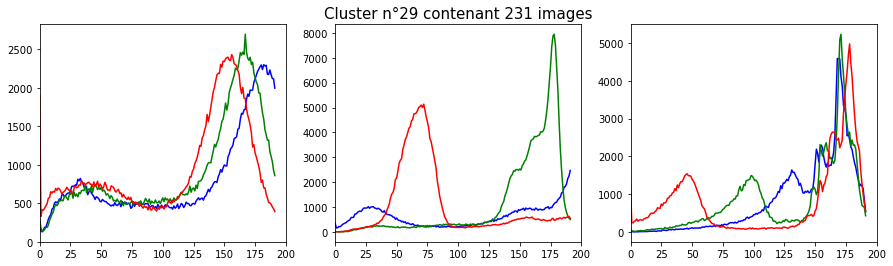

In [22]:
# Plot the histogram of an image in each cluster

color = ('b','g','r')

for k in range(K):
    cluster = list_cluster_image[k]
    
    if len(cluster) >= 3:
        #print("Cluster n°" + str(k))
        #print(len(cluster))
        plt.figure(figsize=(15.0, 4.0))
        
        plt.subplot(1,3,1)
        for i,col in enumerate(color):
            histr = cv2.calcHist([read_image(data_dir+cluster[0])],[i],None,[192],[0,192])
            plt.plot(histr, color = col)
            plt.xlim([0,200])
        
        plt.subplot(1,3,2)
        for i,col in enumerate(color):
            histr = cv2.calcHist([read_image(data_dir+cluster[1])],[i],None,[192],[0,192])
            plt.plot(histr, color = col)
            plt.xlim([0,200])
        plt.title("Cluster n°" + str(k) + " contenant " + str(len(cluster)) + " images", fontsize=15)
            
        plt.subplot(1,3,3)
        for i,col in enumerate(color):
            histr = cv2.calcHist([read_image(data_dir+cluster[2])],[i],None,[192],[0,192])
            plt.plot(histr, color = col)
            plt.xlim([0,200])